# Term Summary Generation

**Задача:**
1. преобразовать экстрактивно извлеченные предложения в RAG-контекст для генеративных моделей;
2. извлечь шапки вики-статей для сравнения (для 10 терминов);
3. настроить промпт генерации абстрактивных выжимок для всех 20 терминов;
4. проверить работу нескольких крупных LLM с RAG-контекстом и без, оценить схожесть ответов с вики-этолоном (ROUGE-score и человеческая оценка). 

In [60]:
import os
import re

from collections import defaultdict

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from nltk import word_tokenize, sent_tokenize, pos_tag, WordPunctTokenizer
from nltk.corpus import stopwords
from razdel import sentenize

import pymorphy2 as pm2

from rouge_score.rouge_scorer import RougeScorer

### 0. Manual Term Tuning

Зададим 20 терминов для проверки LLM и вручную восстановим их правильную грамматическую форму:

In [31]:
# terms with related wiki article
wiki_terms = [
    'акустическая эмиссия',
    'квантовая точка',
    'внутренние волны',
    'волна Рэлея',
    'калибровочные бозоны',
    'меченые атомы',
    'синглетный кислород',
    'число Стокса',
    'число Рэлея',
    'тяжёлая вода',
]

# terms without article
non_wiki_terms = [
    'волна накачки',
    'динамическая рекристаллизация',
    'ионосферная турбулентность',
    'квантовое биение',
    'оптическое выпрямление',
    'паразитная мода',
    'электронная концентрация',
    'хаотическая синхронизация',
    'функция памяти',
    'ударный слой',
]

# combined terms
terms = wiki_terms + non_wiki_terms

len(terms)

20

In [32]:
normalized_to_correct_term = {
    'акустический_эмиссия': 'акустическая эмиссия',
    'квантовый_точка': 'квантовая точка',
    'внутренний_волна': 'внутренние волны',
    'волна_рэлей': 'волна Рэлея',
    'калибровочный_бозон': 'калибровочные бозоны',
    'меченый_атом': 'меченые атомы',
    'синглётный_кислород': 'синглетный кислород',
    'число_стокс': 'число Стокса',
    'число_рэлей': 'число Рэлея',
    'тяжёлый_вода': 'тяжёлая вода',
    'волна_накачка': 'волна накачки',
    'динамический_рекристаллизация': 'динамическая рекристаллизация',
    'ионосферный_турбулентность': 'ионосферная турбулентность',
    'квантовый_биение': 'квантовое биение',
    'оптический_выпрямление': 'оптическое выпрямление',
    'паразитный_мода': 'паразитная мода',
    'электронный_концентрация': 'электронная концентрация',
    'хаотический_синхронизация': 'хаотическая синхронизация',
    'функция_память': 'функция памяти',
    'ударный_слой': 'ударный слой',
}

len(normalized_to_correct_term)

20

### 1. Forging RAG Contexts

In [33]:
extract_dir = '../data/data_frames/eval_20_results'

term_to_context = {}
for filename in tqdm(os.scandir(extract_dir), desc='Forging RAG contexts'):
    term_name = normalized_to_correct_term[filename.name[:-4]]
    term_df = pd.read_csv(filename, index_col=0)

    context = []
    for idx, row in enumerate(term_df.iterrows()):
        context.append(f'{idx + 1}. {row[1].sentence}')

    context = '\n'.join(context)

    term_to_context[term_name] = context

Forging RAG contexts: 0it [00:00, ?it/s]

### 2. Loading Target Texts

Вручную извлечем для 10 терминов "шапку" соответствующих вики-статей:

In [34]:
term_to_target = {
    'акустическая эмиссия': 'Акустическая эмиссия (АЭ) — техническая диагностика, основанная на явлении возникновения и распространения упругих колебаний (акустических волн) в различных процессах, например, при деформации напряжённого материала, истечении газов, жидкостей, горении и взрыве и др.',
    'квантовая точка': '''Квантовая точка (КТ, нанокристал, искусственный атом) — фрагмент проводника или полупроводника (например InGaAs, CdSe, CdS или GaInP/InP), носители заряда (электроны или дырки) которого ограничены в пространстве по всем трём измерениям. Размер квантовой точки должен быть настолько мал, чтобы квантовые эффекты были существенными. Когда их освещают УФ-светом, электрон в квантовой точке может быть возбуждён до состояния с более высокой энергией. В случае полупроводниковой квантовой точки этот процесс соответствует переходу электрона из валентной зоны в зону проводимости. Возбуждённый электрон может вернуться в валентную зону, высвободив свою энергию в виде фотона. Это излучение света (фотолюминесценция) показано на рисунке справа. Цвет этого света зависит от разницы энергий между зоной проводимости и валентной зоной или от перехода между дискретными энергетическими состояниями, когда зонная структура в КТ нечётко определена.

Наноразмерные полупроводниковые материалы плотно удерживают либо электроны, либо дырки. Удержание похоже на частицу в ящике. Особенности поглощения и излучения квантовых точек соответствуют переходам между дискретными квантово-механически разрешёнными уровнями энергии в ящике, напоминающими атомные спектры. По этим причинам квантовые точки иногда называют искусственными «атомами», подчёркивая их связанные и дискретные электронные состояния, подобно встречающимся в природе атомам или молекулам. Электронные волновые функции в квантовых точках напоминают таковые в реальных атомах. Соединив две или более квантовых точек можно создать искусственную «молекулу», проявляющую гибридизацию даже при комнатной температуре. Точная сборка квантовых точек может сформировать сверхрешётки, которые действуют как искусственные твёрдотельные материалы и обладают уникальными оптическими и электронными свойствами.

Квантовые точки обладают промежуточными свойствами между объёмными полупроводниками и отдельными атомами или молекулами. Их оптоэлектронные свойства изменяются в зависимости как от размера, так и от формы. Более крупные КТ диаметром 5—6 нм излучают более длинные волны таких цветов, как оранжевый или красный. КТ меньшего размера (2—3 нм) излучают более короткие волны, создавая синий и зелёный свет. Однако конкретные цвета различаются в зависимости от точного химического состава КТ.

Потенциальные применения квантовых точек включают одноэлектронные транзисторы, солнечные элементы, светодиоды, лазеры, источники одиночных фотонов, генерацию второй гармоники, квантовые вычисления, исследования в клеточной биологии, микроскопию и медицинскую визуализацию. Их небольшой размер позволяет суспендировать некоторые КТ в растворе и использовать их в струйной печати и центрифугировании. Они использовались в тонких плёнках Ленгмюра — Блоджетт. Эти технические средства приводят к созданию менее дорогих и менее трудоёмких методов изготовления полупроводников.

Существует несколько распространённых способов создания квантовых точек. Возможные методы включают коллоидный синтез, самосборку, использование электрического поля и другие.''',
    'внутренние волны': '''Внутренние инерционно-гравитационные волны или внутренние волны — вид волновых движений в стратифицированной жидкости (газе), плотность которой растет с глубиной. Под стратификацией понимается разделение водной толщи водоёма на слои различной плотности.

Наличие неравномерного распределения плотности в среде (жидкости или газе) является необходимым условием для возникновения внутренних волн. Стратификация водоема может возникнуть из-за множества разнообразных явлений, таких как подводные землетрясения, морские течения, таяния льдов, шторма́. С точки зрения физики, изменяется значение двух основных термодинамических параметров — температуры и давления. Не менее важно изменение солености океана, которое напрямую влияет на плотность жидкости.

Также важно отметить, что на больши́х глубинах в океане физическая модель «несжимаемой жидкости» не является верной. По причине значительного давления толщи воды, нижние слои океана являются более плотными, нежели верхние. Такой разницы в плотности достаточно для образования внутренних волн без наличия внешних воздействий (сил).''',
    'волна Рэлея': 'Волны Рэлея — поверхностные акустические волны. Названы в честь Рэлея, теоретически предсказавшего их в 1885 году.',
    'калибровочные бозоны': 'Калибровочные бозоны — бозоны, которые действуют как переносчики фундаментальных взаимодействий. Точнее, элементарные частицы, взаимодействия которых описываются калибровочной теорией, оказывают действие друг на друга при помощи обмена калибровочными бозонами, обычно как виртуальными частицами.',
    'меченые атомы': 'Меченые атомы (изотопные индикаторы) — изотопы, по своим свойствам (радиоактивности, атомной массе) отличающиеся от других изотопов данного элемента, которые добавляют к химическому соединению или смеси, где находится исследуемый элемент. Поведение меченых атомов характеризует поведение элемента в исследуемом процессе. В качестве меченых атомов используют как стабильные (устойчивые) изотопы, так и радиоактивные (неустойчивые) изотопы. Для регистрации радиоактивных меченых атомов применяют счетчики, ионизационные камеры; нерадиоактивные изотопы регистрируют с помощью масс-спектрографов.',
    'синглетный кислород': 'Синглетный кислород — общее название для двух метастабильных состояний молекулярного кислорода (O2) с более высокой энергией, чем в основном, триплетном состоянии. Энергетическая разница между самой низкой энергией O2 в синглетном состоянии и наименьшей энергией триплетного состояния составляет около 11400 кельвин, или 0,98 эВ. Открыт Х. Каутским.',
    'число Стокса': '''Число Стокса (Sk или Stk) — критерий подобия, используемый в гидродинамике взвесей, который определяет соотношение между кинетической энергией взвешенных частиц и энергией их взаимодействия с жидкостью. 
    
Число Стокса позволяет предсказать поведение частиц взвеси, когда жидкость будет огибать препятствие. 

Названо в честь ирландского физика Джорджа Стокса.''',
    'число Рэлея': '''Число Рэлея (Ra) — безразмерное число, определяющее поведение жидкости под воздействием градиента температуры. 
    
Если число Рэлея больше некоторого критического значения, равновесие жидкости становится неустойчивым и возникают конвективные потоки. Возникает бифуркация в динамике жидкости (вилочная бифуркация). Критическое значение числа Рэлея является точкой бифуркации для динамики жидкости. 
    
Число Рэлея можно записать как произведение чисел Грасгофа и Прандтля. 

Данный критерий подобия назван в честь Дж. Стретта (Рэлея).''',
    'тяжёлая вода': 'Тяжёлая вода — обычно этот термин применяется для обозначения тяжеловодородной воды, известной также как оксид дейтерия. Тяжеловодородная вода имеет ту же химическую формулу, что и обычная вода, но вместо двух атомов обычного лёгкого изотопа водорода (протия) содержит два атома тяжёлого изотопа водорода — дейтерия, а её кислород по изотопному составу соответствует кислороду воздуха. Формула тяжеловодородной воды обычно записывается как D2O или 2H2O. Внешне тяжёлая вода выглядит как обычная — бесцветная жидкость без запаха, но обладающая сладковатым вкусом. Не радиоактивна.',
}

len(term_to_target)

10

### 3. Prompt Engineering

Настроим промпт для генеративных моделей. Для оценки влияния промпта и RAG-контекста на итоговое качество рассмотрим 4 варианта:
1. basic prompt;
2. basic prompt + RAG;
3. detailed prompt;
4. detailed prompt + RAG.

Каждый промпт состоит из 3 частей: системная, контекст, вопрос.

In [51]:
system_part_basic = 'Твоя задача - ответить на запрос пользователя.'
system_part_detailed = """Ты - большой эксперт в области физики и химии. Твоя задача - написать основную информацию о запрашиваемом термине.

Структурируй ответ по разделам: Определение, Структура, Использование, Отличительные особенности, Дополнительные сведения. Придерживайся указанного порядка разделов. Разделы не являются обязательными. Если считаешь, что на какой-то раздел недостаточно информации, не пиши его.

Главный критерий качества твоего ответа - фактологическая точность. Пропускай то, в чем не уверен, не лги пользователю. Старайся писать на русском языке."""

context_part_basic = 'Релевантная информация:'
context_part_detailed = """При ответе помимо собственных знаний используй предоставленную релевантную информацию. Если считаешь, что какая-то часть релевантной информации не подходит, не используй ее.

Релевантная информация:"""

question_part = 'Расскажи о следующем термине:'

In [52]:
def create_user_prompt(term, context=None, use_rag=False, use_detailed_prompt=False):
    """Creates user prompt to feed the LLMs."""
    question = question_part + ' ' + term + '.'
    
    if not use_rag:
        if not use_detailed_prompt:
            prompt = '\n\n'.join([system_part_basic, question])
        else:
            prompt = '\n\n'.join([system_part_detailed, question])
    else:
        if not use_detailed_prompt:
            rag_context = context_part_basic + '\n' + context
            prompt = '\n\n'.join([system_part_basic, rag_context, question])
        else:
            rag_context = context_part_detailed + '\n' + context
            prompt = '\n\n'.join([system_part_detailed, rag_context, question])

    return prompt

In [53]:
example_term = 'акустическая эмиссия'
example_context = term_to_context[example_term]

#### 3.1 Basic Prompt

In [54]:
print(create_user_prompt(example_term, context=None, use_rag=False, use_detailed_prompt=False))

Твоя задача - ответить на запрос пользователя.

Расскажи о следующем термине: акустическая эмиссия.


#### 3.2 Basic Prompt + RAG

In [55]:
print(create_user_prompt(example_term, context=example_context, use_rag=True, use_detailed_prompt=False))

Твоя задача - ответить на запрос пользователя.

Релевантная информация:
1. Это оборудование позволяет получать большое количество данных в ходе мониторинга и затем проводить полный анализ сигналов акустической эмиссии, чтобы определить изменение показателя b для всего периода исследований.
2. Акустическая эмиссия (АЭ) - явление, сопутствующее многим физическим процессам в твердом теле.
3. Каждый раз при возникновении акустической эмиссии это событие может привести либо к созданию новой элементарной трещины, либо к распространению существующей трещины на некоторую фиксированную величину (квант разрушения).
4. Поэтому можно считать, что спектральный состав сигнала акустической эмиссии является структурно чувствительной характеристикой.
5. Применение этого метода ограничивается возможностями выделения сигналов акустической эмиссии из помех, то есть данный метод чувствителен только на заключительных этапах жизни образца, когда размеры дефектов уже достаточно велики и приближаются к критиче

#### 3.3 Detailed Prompt

In [56]:
print(create_user_prompt(example_term, context=None, use_rag=False, use_detailed_prompt=True))

Ты - большой эксперт в области физики и химии. Твоя задача - написать основную информацию о запрашиваемом термине.

Структурируй ответ по разделам: Определение, Структура, Использование, Отличительные особенности, Дополнительные сведения. Придерживайся указанного порядка разделов. Разделы не являются обязательными. Если считаешь, что на какой-то раздел недостаточно информации, не пиши его.

Главный критерий качества твоего ответа - фактологическая точность. Пропускай то, в чем не уверен, не лги пользователю. Старайся писать на русском языке.

Расскажи о следующем термине: акустическая эмиссия.


#### 3.4 Detailed Prompt + RAG

In [57]:
print(create_user_prompt(example_term, context=example_context, use_rag=True, use_detailed_prompt=True))

Ты - большой эксперт в области физики и химии. Твоя задача - написать основную информацию о запрашиваемом термине.

Структурируй ответ по разделам: Определение, Структура, Использование, Отличительные особенности, Дополнительные сведения. Придерживайся указанного порядка разделов. Разделы не являются обязательными. Если считаешь, что на какой-то раздел недостаточно информации, не пиши его.

Главный критерий качества твоего ответа - фактологическая точность. Пропускай то, в чем не уверен, не лги пользователю. Старайся писать на русском языке.

При ответе помимо собственных знаний используй предоставленную релевантную информацию. Если считаешь, что какая-то часть релевантной информации не подходит, не используй ее.

Релевантная информация:
1. Это оборудование позволяет получать большое количество данных в ходе мониторинга и затем проводить полный анализ сигналов акустической эмиссии, чтобы определить изменение показателя b для всего периода исследований.
2. Акустическая эмиссия (АЭ) - яв

### 4. Output Quality Evaluation

#### 4.1 Best Prompting Strategy

Определим лучший подход к созданию промпта. В качестве модели будем использовать Meta-Llama-3-70B-Instruct со следующими параметрами генерации:
- sampling_temperature = 0.2;
- beam search beam width = 7;
- token repetition penalty = 1.05.

In [58]:
prompt_testing_dir = '../data/llm_generation/prompt_testing'

# basic
current_dir = prompt_testing_dir + '/basic/'
with open(current_dir + 'prompts.txt', 'w', encoding='utf-8') as f:
    for term in wiki_terms:
        prompt = create_user_prompt(term, context=None, use_rag=False, use_detailed_prompt=False)
        f.write(prompt)

        f.write('\n\n')
        f.write('=' * 120)
        f.write('\n\n')

# basic + RAG
current_dir = prompt_testing_dir + '/basic_rag/'
with open(current_dir + 'prompts.txt', 'w', encoding='utf-8') as f:
    for term in wiki_terms:
        prompt = create_user_prompt(term, context=term_to_context[term], use_rag=True, use_detailed_prompt=False)
        f.write(prompt)

        f.write('\n\n')
        f.write('=' * 120)
        f.write('\n\n')

# detailed
current_dir = prompt_testing_dir + '/detailed/'
with open(current_dir + 'prompts.txt', 'w', encoding='utf-8') as f:
    for term in wiki_terms:
        prompt = create_user_prompt(term, context=None, use_rag=False, use_detailed_prompt=True)
        f.write(prompt)

        f.write('\n\n')
        f.write('=' * 120)
        f.write('\n\n')

# detailed + RAG
current_dir = prompt_testing_dir + '/detailed_rag/'
with open(current_dir + 'prompts.txt', 'w', encoding='utf-8') as f:
    for term in wiki_terms:
        prompt = create_user_prompt(term, context=term_to_context[term], use_rag=True, use_detailed_prompt=True)
        f.write(prompt)

        f.write('\n\n')
        f.write('=' * 120)
        f.write('\n\n')

Ответы модели вручную запишем в соответсвтующие файлы 'responses.txt'.

Воспользуемся набором метрик ROUGE для сравнения ответа с вики-эталоном:

In [61]:
tokenizer = WordPunctTokenizer()
scorer = RougeScorer(['rouge1', 'rouge2', 'rougeL', 'rougeLsum'], split_summaries=True, tokenizer=tokenizer)

In [79]:
# basic
responses = []
current_dir = prompt_testing_dir + '/basic/'
with open(current_dir + 'responses.txt', 'r', encoding='utf-8') as f:
    response = []
    
    for line in f:
        if line.startswith('==='):
            responses.append(''.join(response).strip())
            response=[]
        else:
            response.append(line)
    
term_to_response = {}
for idx, term in enumerate(wiki_terms):
    term_to_response[term] = responses[idx]

Выведем усредненное значение F-меры по ROUGE-1, ROUGE-2, ROUGE-L, ROUGE-Lsum:

In [88]:
rouge1_avg, rouge2_avg, rougeL_avg, rougeLsum_avg = 0, 0, 0, 0

for term in wiki_terms:
    target = term_to_target[term]
    prediction = term_to_response[term]

    scores = scorer.score(target, prediction)

    rouge1_avg += scores['rouge1'].fmeasure
    rouge2_avg += scores['rouge2'].fmeasure
    rougeL_avg += scores['rougeL'].fmeasure
    rougeLsum_avg += scores['rougeLsum'].fmeasure

rouge1_avg /= len(wiki_terms)
rouge2_avg /= len(wiki_terms)
rougeL_avg /= len(wiki_terms)
rougeLsum_avg /= len(wiki_terms)

print('rouge1:', rouge1_avg)
print('rouge2:', rouge2_avg)
print('rougeL:', rougeL_avg)
print('rougeLsum:', rougeLsum_avg)

rouge1: 0.1852519182961072
rouge2: 0.04976516829680764
rougeL: 0.12274167496534646
rougeLsum: 0.17797888072845663


In [89]:
# basic + RAG
responses = []
current_dir = prompt_testing_dir + '/basic_rag/'
with open(current_dir + 'responses.txt', 'r', encoding='utf-8') as f:
    response = []
    
    for line in f:
        if line.startswith('==='):
            responses.append(''.join(response).strip())
            response=[]
        else:
            response.append(line)
    
term_to_response = {}
for idx, term in enumerate(wiki_terms):
    term_to_response[term] = responses[idx]

Выведем усредненное значение F-меры по ROUGE-1, ROUGE-2, ROUGE-L, ROUGE-Lsum:

In [90]:
rouge1_avg, rouge2_avg, rougeL_avg, rougeLsum_avg = 0, 0, 0, 0

for term in wiki_terms:
    target = term_to_target[term]
    prediction = term_to_response[term]

    scores = scorer.score(target, prediction)

    rouge1_avg += scores['rouge1'].fmeasure
    rouge2_avg += scores['rouge2'].fmeasure
    rougeL_avg += scores['rougeL'].fmeasure
    rougeLsum_avg += scores['rougeLsum'].fmeasure

rouge1_avg /= len(wiki_terms)
rouge2_avg /= len(wiki_terms)
rougeL_avg /= len(wiki_terms)
rougeLsum_avg /= len(wiki_terms)

print('rouge1:', rouge1_avg)
print('rouge2:', rouge2_avg)
print('rougeL:', rougeL_avg)
print('rougeLsum:', rougeLsum_avg)

rouge1: 0.21136994657746538
rouge2: 0.04556782125544582
rougeL: 0.14654844657574545
rougeLsum: 0.1938355279152893


In [91]:
# detailed
responses = []
current_dir = prompt_testing_dir + '/detailed/'
with open(current_dir + 'responses.txt', 'r', encoding='utf-8') as f:
    response = []
    
    for line in f:
        if line.startswith('==='):
            responses.append(''.join(response).strip())
            response=[]
        else:
            response.append(line)
    
term_to_response = {}
for idx, term in enumerate(wiki_terms):
    term_to_response[term] = responses[idx]

Выведем усредненное значение F-меры по ROUGE-1, ROUGE-2, ROUGE-L, ROUGE-Lsum:

In [92]:
rouge1_avg, rouge2_avg, rougeL_avg, rougeLsum_avg = 0, 0, 0, 0

for term in wiki_terms:
    target = term_to_target[term]
    prediction = term_to_response[term]

    scores = scorer.score(target, prediction)

    rouge1_avg += scores['rouge1'].fmeasure
    rouge2_avg += scores['rouge2'].fmeasure
    rougeL_avg += scores['rougeL'].fmeasure
    rougeLsum_avg += scores['rougeLsum'].fmeasure

rouge1_avg /= len(wiki_terms)
rouge2_avg /= len(wiki_terms)
rougeL_avg /= len(wiki_terms)
rougeLsum_avg /= len(wiki_terms)

print('rouge1:', rouge1_avg)
print('rouge2:', rouge2_avg)
print('rougeL:', rougeL_avg)
print('rougeLsum:', rougeLsum_avg)

rouge1: 0.18609380081930374
rouge2: 0.04823157219052166
rougeL: 0.12620430073481753
rougeLsum: 0.1735089739936986


In [93]:
# detailed + RAG
responses = []
current_dir = prompt_testing_dir + '/detailed_rag/'
with open(current_dir + 'responses.txt', 'r', encoding='utf-8') as f:
    response = []
    
    for line in f:
        if line.startswith('==='):
            responses.append(''.join(response).strip())
            response=[]
        else:
            response.append(line)
    
term_to_response = {}
for idx, term in enumerate(wiki_terms):
    term_to_response[term] = responses[idx]

Выведем усредненное значение F-меры по ROUGE-1, ROUGE-2, ROUGE-L, ROUGE-Lsum:

In [94]:
rouge1_avg, rouge2_avg, rougeL_avg, rougeLsum_avg = 0, 0, 0, 0

for term in wiki_terms:
    target = term_to_target[term]
    prediction = term_to_response[term]

    scores = scorer.score(target, prediction)

    rouge1_avg += scores['rouge1'].fmeasure
    rouge2_avg += scores['rouge2'].fmeasure
    rougeL_avg += scores['rougeL'].fmeasure
    rougeLsum_avg += scores['rougeLsum'].fmeasure

rouge1_avg /= len(wiki_terms)
rouge2_avg /= len(wiki_terms)
rougeL_avg /= len(wiki_terms)
rougeLsum_avg /= len(wiki_terms)

print('rouge1:', rouge1_avg)
print('rouge2:', rouge2_avg)
print('rougeL:', rougeL_avg)
print('rougeLsum:', rougeLsum_avg)

rouge1: 0.1893957806389933
rouge2: 0.05011676676097378
rougeL: 0.13104466162639045
rougeLsum: 0.17425975829826398


Запишем показатели ROUGE в таблицу:

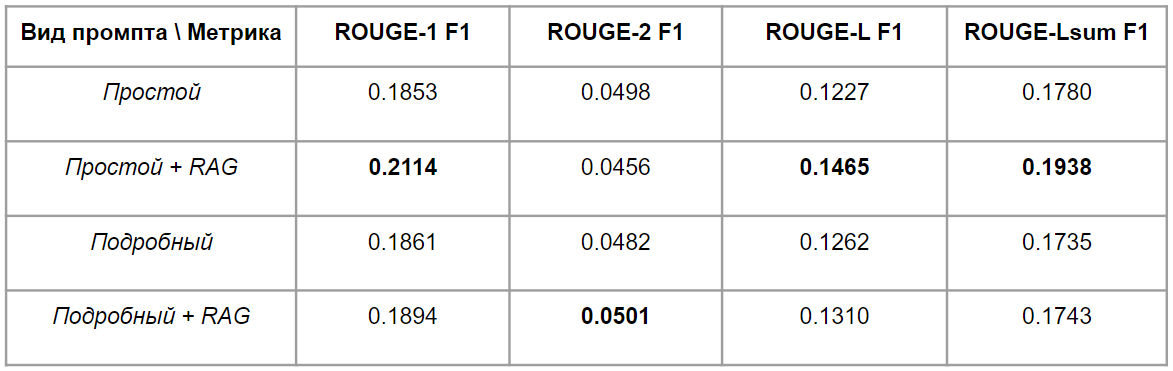

По оценкам ROUGE все промпты близки по качеству. RAG дает маленький прирост. Могу предположить, что простой промпт немного опережает детализированный из-за дефолтных настроек LLM. Велика вероятность, что без детальных инструкций модель отвечает по некоторому шаблону, который, возможно, похож на аннотации статей с Википедии (а они и есть эталонные тексты).

Таким образом, автоматические метрики немного говорят о качестве. Оценим тогда визульное качество ответов на примере термина "квантовая точка".

**<u>basic</u>**

Квантовая точка (Quantum Dot, QD) - это ультрамаленькая частица, размером от 2 до 10 нанометров, которая состоит из группы атомов, обычно из полупроводниковых материалов, таких как кадмий селенид (CdSe) или свинец сульфид (PbS).

Квантовые точки имеют уникальные оптические и электронные свойства, которые отличаются от свойств больших кристаллов тех же материалов. Это происходит потому, что в квантовой точке электроны и дырки (положительно заряженные квазичастицы) ограничены в трех измерениях, что приводит к квантованию энергетических уровней.

Основные свойства квантовых точек:

1. **Квантование энергии**: Энергия электронов и дырок в квантовой точке квантуется, то есть может принимать только определенные дискретные значения.
2. **Флуоресценция**: Квантовые точки могут испускать свет при возбуждении электронами или фотонами. Цвет испускаемого света зависит от размера квантовой точки.
3. **Высокая эффективность квантового выхода**: Квантовые точки могут иметь высокую эффективность квантового выхода, что означает, что большая часть поглощенной энергии преобразуется в свет.
4. **Устойчивость к фотоокислению**: Квантовые точки более устойчивы к фотоокислению, чем традиционные органические флуорофоры.

Применения квантовых точек:

1. **Биомедицина**: Квантовые точки используются в биомедицинских исследованиях для маркирования клеток и наблюдения за их поведением.
2. **Дисплеи**: Квантовые точки используются в дисплеях для создания ярких и насыщенных цветов.
3. **Солнечные батареи**: Квантовые точки исследуются для использования в солнечных батареях для увеличения их эффективности.
4. **Квантовые компьютеры**: Квантовые точки могут быть использованы в квантовых компьютерах для хранения и обработки квантовой информации.

В целом, квантовые точки - это интересный класс материалов с уникальными свойствами, которые открывают новые возможности для различных областей науки и технологии.

**<u>basic + RAG</u>**

Квантовая точка - это фрагмент проводника или полупроводника, образующий трехмерную структуру с размерами в несколько единиц или десятков нанометров, способную удерживать счетное количество электронов (порядка 100 и менее). Электрон в квантовой точке имеет много дискретных квазистационарных уровней энергии и чувствует себя как частица в трехмерной потенциальной яме.

Квантовые точки - это нуль-мерные (0D) структуры, в которых движение носителей заряда ограничено во всех трех направлениях. Они представляют собой пример квантования состояний электронов в нульмерном (0D) пространстве.

Квантовая точка может быть описана как искусственный атом, свойствами которого можно управлять. Она состоит из ограниченного числа атомов и может быть внедрена в тело полупроводника, образуя своеобразную ловушку для электрона.

Квантовые точки имеют высокую стабильность и могут быть использованы в различных областях, таких как электроника, оптика, биология и медицина. Они могут быть использованы для создания новых типов электронных устройств, таких как одноэлектронные транзисторы, квантовые ячейки памяти и другие.

Однако, квантовые точки также имеют свои ограничения и проблемы, такие как токсичность, чувствительность к зарядовому состоянию и ограничения в масштабируемости.

**<u>detailed</u>**

**Квантовая точка**

**Определение**
Квантовая точка (quantum dot) - это ультрамаленькое полупроводниковое образование, размером от 2 до 10 нанометров, которое демонстрирует квантовые свойства из-за ограничения движения электронов и дырок в трех измерениях.

**Структура**
Квантовая точка обычно состоит из ядра, сделанного из полупроводникового материала, окруженного оболочкой из другого материала. Ядро может быть сделано из таких материалов, как кадмий селенид (CdSe), кадмий теллурид (CdTe) или свинец сульфид (PbS). Оболочка изолирует ядро от окружающей среды и предотвращает рекомбинацию электронов и дырок.

**Использование**
Квантовые точки используются в различных областях, включая:

* Оптоэлектронику: квантовые точки могут быть использованы для создания высокоэффективных светоизлучающих диодов (LED) и лазеров.
* Биомедицину: квантовые точки могут быть использованы для маркирования биомолекул и визуализации процессов в живых клетках.
* Фотovoltaику: квантовые точки могут быть использованы для создания высокоэффективных солнечных батарей.

**Отличительные особенности**
Квантовые точки имеют несколько отличительных особенностей, которые делают их полезными для различных приложений:

* Квантовый эффект размера: квантовые точки демонстрируют квантовые свойства из-за ограничения движения электронов и дырок в трех измерениях.
* Высокая люминесценция: квантовые точки могут излучать свет с высокой эффективностью.
* Регулируемый спектр: спектр излучения квантовой точки может быть регулирован изменением ее размера и формы.

**Дополнительные сведения**
Квантовые точки были впервые синтезированы в 1980-х годах, и с тех пор они привлекли внимание ученых и инженеров из-за своих уникальных свойств. Сейчас квантовые точки используются в различных областях, включая оптоэлектронику, биомедицину и фотovoltaику.

**<u>detailed + RAG</u>**

**Определение**

Квантовая точка - это фрагмент проводника или полупроводника, образующий трехмерную структуру с размерами в несколько единиц или десятков нанометров, способную удерживать счетное количество электронов (порядка 100 и менее). Электрон в квантовой точке имеет много дискретных квазистационарных уровней энергии и чувствует себя как частица в трехмерной потенциальной яме.

**Структура**

Квантовая точка - это небольшие острова двумерной частицы, окруженные искусственным потенциалом. Она ограничена по всем трем пространственным измерениям и содержит электроны проводимости. Квантовые точки - это нуль-мерные (0D) структуры, в которых движение носителей заряда ограничено во всех трех направлениях.

**Использование**

Квантовые точки используются в различных областях, таких как электроника, оптика, биология и медицина. Они могут быть использованы для создания новых типов транзисторов, таких как одноэлектронные транзисторы, а также для разработки новых методов оптической диагностики в биологии и медицине.

**Отличительные особенности**

Квантовые точки имеют несколько отличительных особенностей, таких как:

* Ограничение движения носителей заряда по всем трем координатам
* Дискретные квазистационарные уровни энергии электронов
* Способность удерживать счетное количество электронов
* Высокий квантовый выход, что делает их яркими в биологических объектах

**Дополнительные сведения**

Квантовые точки могут быть внедрены эндоцитозом или с помощью маркированных мембранных белков. Они могут быть использованы для создания новых типов ячеек памяти, таких как одиночная заряженная квантовая точка. Кроме того, квантовые точки имеют высокую стабильность, что делает их привлекательными для использования вразличных приложениях.
едицину и фотovoltaику.

*<u>Выводы:</u>* 

- подробный промпт способствует лучшей структуре ответа, что приветствуется при написании научных текстов. Вполне возможно, что именно заголовки портили ROUGE-оценки. Субъективно, но структура выдачи стала намного лучше при использовании подробных инструкций;
- модель активно использует RAG, что делает ответ менее шаблонным. Вообще говоря, RAG не всегда способствует улучшению качества, особенно когда базовая модель сама по себе много знает. Однако это не наш случай - мы работает с достаточно редкими терминами, где RAG очень помогает. Более того, RAG позволит модели адекватно ответить даже в том случае, когда она сама почти ничего не знает.

Таким образом, будем использовать вариацию **detailed + RAG**, т.е. подробный промпт вместе с RAG.

#### 4.2 Best Model

Теперь выберем оптимальную LLM. Рассмотрим 3 варианта:
1. Meta-Llama-3-70B-Instruct;
2. Claude-3-sonnet-20240229;
3. Mixtral-8x22b-instruct-v0.1;

LLama-3 уже рассмотрели. Оценим 2 оставшиеся модели:

In [97]:
model_testing_dir = '../data/llm_generation/model_testing'

In [98]:
# claude-3
responses = []
current_dir = model_testing_dir + '/claude-3-sonnet-20240229/'
with open(current_dir + 'responses.txt', 'r', encoding='utf-8') as f:
    response = []
    
    for line in f:
        if line.startswith('==='):
            responses.append(''.join(response).strip())
            response=[]
        else:
            response.append(line)
    
term_to_response = {}
for idx, term in enumerate(wiki_terms):
    term_to_response[term] = responses[idx]

Выведем усредненное значение F-меры по ROUGE-1, ROUGE-2, ROUGE-L, ROUGE-Lsum:

In [99]:
rouge1_avg, rouge2_avg, rougeL_avg, rougeLsum_avg = 0, 0, 0, 0

for term in wiki_terms:
    target = term_to_target[term]
    prediction = term_to_response[term]

    scores = scorer.score(target, prediction)

    rouge1_avg += scores['rouge1'].fmeasure
    rouge2_avg += scores['rouge2'].fmeasure
    rougeL_avg += scores['rougeL'].fmeasure
    rougeLsum_avg += scores['rougeLsum'].fmeasure

rouge1_avg /= len(wiki_terms)
rouge2_avg /= len(wiki_terms)
rougeL_avg /= len(wiki_terms)
rougeLsum_avg /= len(wiki_terms)

print('rouge1:', rouge1_avg)
print('rouge2:', rouge2_avg)
print('rougeL:', rougeL_avg)
print('rougeLsum:', rougeLsum_avg)

rouge1: 0.19216155660308815
rouge2: 0.041525553494071596
rougeL: 0.12096761048308728
rougeLsum: 0.17559546468444215


In [100]:
# mixtral
responses = []
current_dir = model_testing_dir + '/mixtral-8x22b-instruct-v0.1/'
with open(current_dir + 'responses.txt', 'r', encoding='utf-8') as f:
    response = []
    
    for line in f:
        if line.startswith('==='):
            responses.append(''.join(response).strip())
            response=[]
        else:
            response.append(line)
    
term_to_response = {}
for idx, term in enumerate(wiki_terms):
    term_to_response[term] = responses[idx]

Выведем усредненное значение F-меры по ROUGE-1, ROUGE-2, ROUGE-L, ROUGE-Lsum:

In [101]:
rouge1_avg, rouge2_avg, rougeL_avg, rougeLsum_avg = 0, 0, 0, 0

for term in wiki_terms:
    target = term_to_target[term]
    prediction = term_to_response[term]

    scores = scorer.score(target, prediction)

    rouge1_avg += scores['rouge1'].fmeasure
    rouge2_avg += scores['rouge2'].fmeasure
    rougeL_avg += scores['rougeL'].fmeasure
    rougeLsum_avg += scores['rougeLsum'].fmeasure

rouge1_avg /= len(wiki_terms)
rouge2_avg /= len(wiki_terms)
rougeL_avg /= len(wiki_terms)
rougeLsum_avg /= len(wiki_terms)

print('rouge1:', rouge1_avg)
print('rouge2:', rouge2_avg)
print('rougeL:', rougeL_avg)
print('rougeLsum:', rougeLsum_avg)

rouge1: 0.18270529348563427
rouge2: 0.034341246589233106
rougeL: 0.13393260271660107
rougeLsum: 0.17261290808249846


Запишем показатели ROUGE в таблицу:

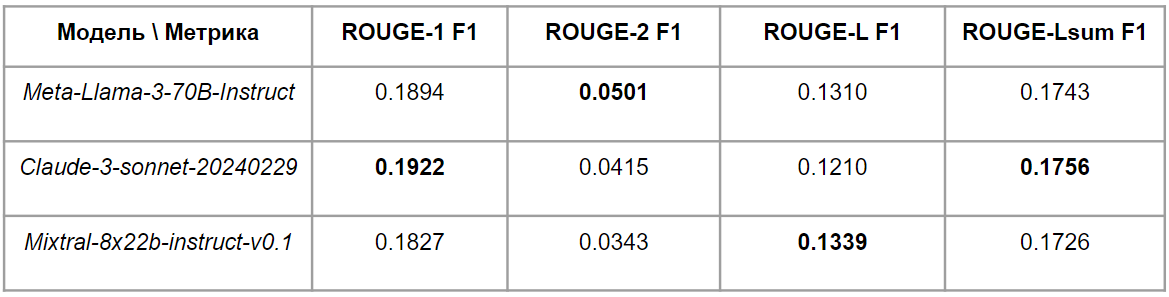

Как и в случае оценивания промптов, разница между моделями небольшая. Оценим вручную качество ответов на примере термина "меченые атомы":

**<u>RAG-context:</u>**

1. ПРАКТИЧЕСКОЕ ИСПОЛЬЗОВАНИЕ ИОНИЗИРУЮЩИХ ИЗЛУЧЕНИЙ Область применения ионизирующих излучений очень широка: - в промышленности - это гигантские реакторы для атомных электростанций, для опреснения морской и засолённой воды, для получения трансурановых элементов; также их используют в активационном анализе для быстрого определения примесей в сплавах, металла в руде, качества угля; - в сельском хозяйстве - это установки для массового облучения овощей с целью предохранения их от плесени, мяса - от порчи; выведение новых сортов путём генетических мутаций; - в геологии - это нейтронный каротаж для поисков нефти, активационный анализ для поисков и сортировки металлических руд, для определения массовой доли примесей в естественных алмазах; - в медицине - это изучение производственных отравлений методом меченых атомов, диагностика заболевания при помощи активационного анализа, метода меченых атомов и радиографии, лечение опухолей г-лучами и в-частицами, стерилизация фармацевтических препаратов, одежды, медицинских инструментов и оборудования г-излучением.
2. Концентрация меченых атомов обычно очень мала, чтобы состав образца существенно не изменялся.
3. Данный метод позволяет в качестве метки использовать не только изотоп, но и меченый атом с теми же физическими и химическими характеристиками, что и не меченый атом.
4. Численное моделирование процессов горения (распространения пламени, самовоспламенения и т. д.) также позволяет использовать метод меченых атомов, причем возможности этого метода в данном случае могут оказаться столь же продуктивными.
5. Такие коэффициенты корреляции выражают взаимосвязь направлений перескока данного меченого атома (эффекты корреляции меченых атомов) или направлений перескока центра массы данного атома с атомами того же или другого сорта (коллективные корреляции).
6. Меченые атомы (изотопы) могут быть как атомами одного из основных компонентов сплава, так и атомами примеси.
7. Тогда соотношение Хавена ведет себя примерно так же, как корреляционный множитель меченых атомов в отсутствие взаимодействия, то есть при простом блокировании расстояния между атомами.
8. Первый из них связан с измерением диффузии меченых атомов (стабильных или радиоактивных изотопов).


**<u>Meta-Llama-3-70B-Instruct:</u>**

**Меченые атомы**

**Определение**
Меченые атомы - это атомы, помеченные радиоактивными или стабильными изотопами, которые используются для исследования различных процессов и явлений в физике, химии, биологии и других областях науки.

**Структура**
Меченые атомы могут быть как атомами одного из основных компонентов сплава, так и атомами примеси. Они имеют те же физические и химические характеристики, что и не меченые атомы, но отличаются наличием радиоактивных или стабильных изотопов.

**Использование**
Меченые атомы используются в различных областях, таких как:

* промышленность: активационный анализ для быстрого определения примесей в сплавах, металла в руде, качества угля;
* сельское хозяйство: массовое облучение овощей для предохранения от плесени, мяса - от порчи; выведение новых сортов путём генетических мутаций;
* геология: нейтронный каротаж для поисков нефти, активационный анализ для поисков и сортировки металлических руд, для определения массовой доли примесей в естественных алмазах;
* медицина: изучение производственных отравлений методом меченых атомов, диагностика заболевания при помощи активационного анализа, метода меченых атомов и радиографии, лечение опухолей г-лучами и в-частицами, стерилизация фармацевтических препаратов, одежды, медицинских инструментов и оборудования г-излучением.

**Отличительные особенности**
Меченые атомы позволяют в качестве метки использовать не только изотоп, но и меченый атом с теми же физическими и химическими характеристиками, что и не меченый атом. Кроме того, концентрация меченых атомов обычно очень мала, чтобы состав образца существенно не изменялся.

**Дополнительные сведения**
Меченые атомы также используются в численном моделировании процессов горения, где возможности этого метода могут оказаться столь же продуктивными. Коэффициенты корреляции, полученные с помощью меченых атомов, выражают взаимосвязь направлений перескока данного меченого атома или направлений перескока центра массы данного атома с атомами того ж или другого сорта.


**<u>Claude-3-sonnet-20240229:</u>**

Определение:
Меченые атомы - это атомы, содержащие радиоактивные или стабильные изотопы, которые используются в качестве меток для отслеживания их поведения в различных физических, химических и биологических процессах.

Структура:
Меченые атомы представляют собой обычные атомы, в которых один или несколько нуклонов (протонов или нейтронов) заменены на изотопы с другим массовым числом. Они сохраняют химические свойства немеченых атомов, но могут быть обнаружены благодаря своей радиоактивности или другим уникальным свойствам.

Использование:
Метод меченых атомов широко применяется в различных областях науки и техники:
- Исследование химических реакций и механизмов переноса
- Изучение процессов диффузии и самодиффузии в твердых телах
- Исследование метаболических процессов в биологии и медицине
- Анализ состава материалов (активационный анализ)
- Отслеживание потоков и распределения веществ в окружающей среде

Отличительные особенности:
1. Сохраняют химические свойства немеченых атомов
2. Могут быть радиоактивными или стабильными
3. Позволяют отслеживать поведение атомов в процессах
4. Используются в очень малых концентрациях

Дополнительные сведения:
Концентрация меченых атомов обычно очень мала, чтобы не изменять существенно состав образца. Радиоактивные меченые атомы могут быть обнаружены с высокой чувствительностью по их излучению. Метод меченых атомов является неразрушающим и позволяет получать уникальную информацию о протекающих процессх на атомном уровне.


**<u>Mixtral-8x22b-instruct-v0.1:</u>**

Определение: Меченые атомы - это атомы, которые были специально модифицированы для использования в качестве метки в различных приложениях, таких как медицина, сельское хозяйство и промышленность. Меченые атомы могут быть как атомами одного из основных компонентов сплава, так и атомами примеси.

Структура: Меченые атомы могут быть модифицированы путем добавления радиоактивного изотопа, который позволяет отслеживать их движение и распределение в образце. Концентрация меченых атомов обычно очень мала, чтобы состав образца существенно не изменялся.

Использование: Меченые атомы используются в различных областях, таких как медицина, сельское хозяйство и промышленность. В медицине они могут использоваться для диагностики заболевания при помощи активационного анализа, метода меченых атомов и радиографии, а также для лечения опухолей и стерилизации фармацевтических препаратов. В сельском хозяйстве они могут использоваться для выведения новых сортов путем генетических мутаций. В промышленности они могут использоваться для опреснения морской и засолённой воды, для получения трансурановых элементов и для активационного анализа для быстрого определения примесей в сплавах и металла в руде.

Отличительные особенности: Меченые атомы отличаются от обычных атомов тем, что они были специально модифицированы для использования в качестве метки. Они могут содержать радиоактивный изотоп, который позволяет отслеживать их движение и распределение в образце. Меченые атомы могут быть как атомами одного из основных компонентов сплава, так и атомами примеси.

Дополнительные сведения: Меченые атомы могут использоваться для изучения процессов горения, в частности, распространения пламени и самовоспламенения. Они также могут использоваться для измерения диффузии меченых атомов и для изучения взаимосвязи направлений перескока данного меченого атома или направлений перескока центра массы данного атома с атомами того же или другого сорта.


*<u>Выводы:</u>* 

- Llama и Mixtral активно используют предоставленный RAG-контекст (но Llama активнее), Claude очень консервативен в этом смысле - он предпочитает использовать собственные знания. Иногда это правда может улучшить качество (когда в контекст попадает явно нерелевантная информация), однако в нашем случае RAG чаще полезен, чем вреден;
- Наихудшее форматирование ответа у Mixtral, LLama и Claude в целом равны между собой.
- В отличие от Claude, LLama и Mixtral - open-source модели, что тоже немаловажный плюс (как минимум, не нужна подписка, и возможна автоматизация процесса общения).

Таким образом, все модели хороши. Но для поставленной задачи я считаю, что лучше всего подойдет **Meta-Llama-3-70B-Instruct**.

### 5. Summary Generation

Для вики-терминов мы уже сгенерировали выжимки. Сделаем то же самое для 10 не-вики-терминов:

In [102]:
final_dir = '../data/llm_generation/final_summaries/non_wiki_terms/'
with open(final_dir + 'prompts.txt', 'w', encoding='utf-8') as f:
    for term in non_wiki_terms:
        prompt = create_user_prompt(term, context=term_to_context[term], use_rag=True, use_detailed_prompt=True)
        f.write(prompt)

        f.write('\n\n')
        f.write('=' * 120)
        f.write('\n\n')

### 6. Notes

1. Даже коммерческие модели типа Claude можно использовать бесплатно (но с различными ограничениями) на платформе LMSYS Arena (именно там и генерил выдачу для Claude и Mixtral);
2. Можно заметить, что модели иногда повторяют при ответе предложения из RAG-контекста. Особенно это заметно для терминов без вики-статьи. Возможно, у модели не хватает собственных знаний, а RAG-контекст либо беден, либо нерелевантен по мнению модели;
3. В дополнительные сведения LLM сбрасывают все, что не смогли отнести к другим категориям, иногда ошибочно (особенно часто случается с предложениями, подходящими в раздел Использование);
4. Оценить содержание таких специфичных терминов для меня достаточно проблематично, поэтому при выборе модели ориентировался на общую связность повествования и интенсивность использования контекста (чаще он полезен, чем вреден).